# A. Compare VQ-VAE & VAE

The latent space is more semantic & interpretable. As said in the question, there is no animal between cat and dog. So discrete latent spacehaelp us to be more across data examples.

VQ-VAE's discrete latent bottleneck forces the model to use the latents. So it avoids posterior collapse(ignoring latent code because decoder is complex and encoder is simple).

#  B. Implement Main Parts of Model

Residual block is defined to improve performance of encoder and decoder by reducing gradient vanishing. Then implement encoder and decoder.

In [108]:
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels):
        super(Residual, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
        )

    def forward(self, x):
        residual = x
        x = self.block(x)
        x = x + residual
        return x

class ResidualBlocks(nn.Module):
    def __init__(self, in_channels, out_channels, residual_layers, hidden_channels):
        super(ResidualBlocks, self).__init__()
        self.residual_layers = residual_layers
        self.layers = nn.ModuleList(
            [
                Residual(in_channels, out_channels, hidden_channels)
                for _ in range(self.residual_layers)
            ]
        )

    def forward(self, x):
        for i in range(self.residual_layers):
            x = x + self.layers[i](x)
            x = F.relu(x)
        return x

In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=2)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.residual_block = ResidualBlocks(128, 128, 2, 32)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.residual_block(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv0 = ResidualBlocks(128, 128, 2, 32)
        self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=2)
        self.conv3 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.conv0(x)
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x


In [110]:
class VectorQuantization(nn.Module):
    def __init__(self, number_embeddings, embedding_dimension):
        super(VectorQuantization, self).__init__()

        self.num_embeddings = number_embeddings
        self.embedding_dim = embedding_dimension

        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.uniform_(-1 / self.num_embeddings, 1 / self.num_embeddings)

    def forward(self, x):
        # Convert BCHW to BHWC
        x = x.permute(0, 2, 3, 1)

        # Flatten input
        latent = x.reshape(-1, self.embedding_dim)

        # Calculate the L2 Norm between latent and Embedded weights
        distances = (torch.sum(latent**2, dim=1, keepdim=True) +
                     torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(latent, self.embedding.weight.t()))

        # Encoding starts from here
        encoded_indices = torch.argmin(distances, dim=1).unsqueeze(1)

        encoded_vector = F.one_hot(encoded_indices, self.num_embeddings).type(x.dtype)
        encoded_vector = encoded_vector.view(encoded_vector.shape[0], encoded_vector.shape[2])

        # Quantization of the Encodings
        quantized_vector = torch.matmul(encoded_vector, self.embedding.weight)
        quantized_vector = quantized_vector.view(x.shape)

        beta = 0.25
        commitment_loss = F.mse_loss(quantized_vector.detach(), x)
        codebook_loss = F.mse_loss(quantized_vector, x.detach())
        vq_loss = codebook_loss + beta * commitment_loss

        # Detach and update quantized vector for backpropagation
        quantized_vector = x + (quantized_vector - x).detach()
        quantized_vector = quantized_vector.permute(0, 3, 1, 2)

        return quantized_vector, vq_loss

here we defined our main model.

In [129]:
class VQVAENet(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(VQVAENet, self).__init__()
        self.encoder = Encoder()
        self.hidden1 = nn.Conv2d(128, embedding_dim, 1, 1)
        self.vq = VectorQuantization(num_embeddings, embedding_dim)
        self.hidden2 = nn.Conv2d(embedding_dim, 128, 3, 1, 1)
        self.decoder = Decoder()

    def forward(self, x):
        enc_out = self.encoder(x)
        pre_qv = self.hidden1(enc_out)
        quantized_vector, vq_loss = self.vq(pre_qv)
        post_qv = self.hidden2(quantized_vector)
        x = self.decoder(post_qv)

        return x, vq_loss, quantized_vector

it's time to train the model.

Epoch 1, Loss: 0.06936369091272354
Epoch 2, Loss: 0.05460056662559509
Epoch 3, Loss: 0.0560915470123291
Epoch 4, Loss: 0.051083244383335114
Epoch 5, Loss: 0.0517968125641346
Epoch 6, Loss: 0.05368044972419739
Epoch 7, Loss: 0.05081555247306824
Epoch 8, Loss: 0.04887846112251282
Epoch 9, Loss: 0.05155530944466591
Epoch 10, Loss: 0.05027185380458832


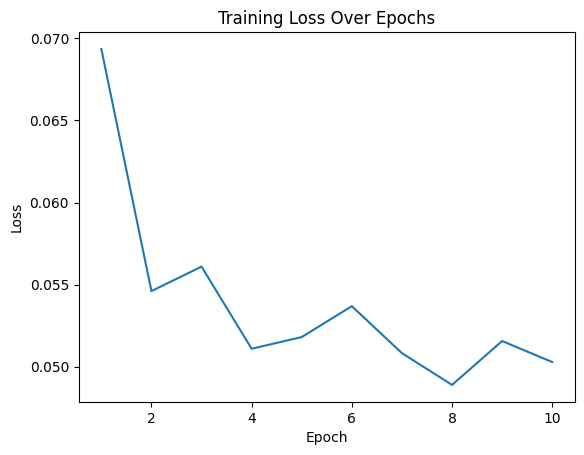

In [150]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

losses = []

# Load MNIST dataset ...
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Initialize the model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VQVAENet(3,2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop
codebook_vectors = []
model.train()
num_epochs = 10
for epoch in range(num_epochs):
    for images, _ in train_loader:
        images = images.to(device)

        optimizer.zero_grad()

        output, vq_loss, pqv = model(images)

        loss = F.mse_loss(output, images) + vq_loss

        loss.backward()
        optimizer.step()

    codebook_vectors.append(model.vq.embedding.weight.clone().detach().cpu().numpy())

    # scheduler.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    losses.append(loss.item())

plt.plot(range(1, num_epochs+1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

# C. Model Results

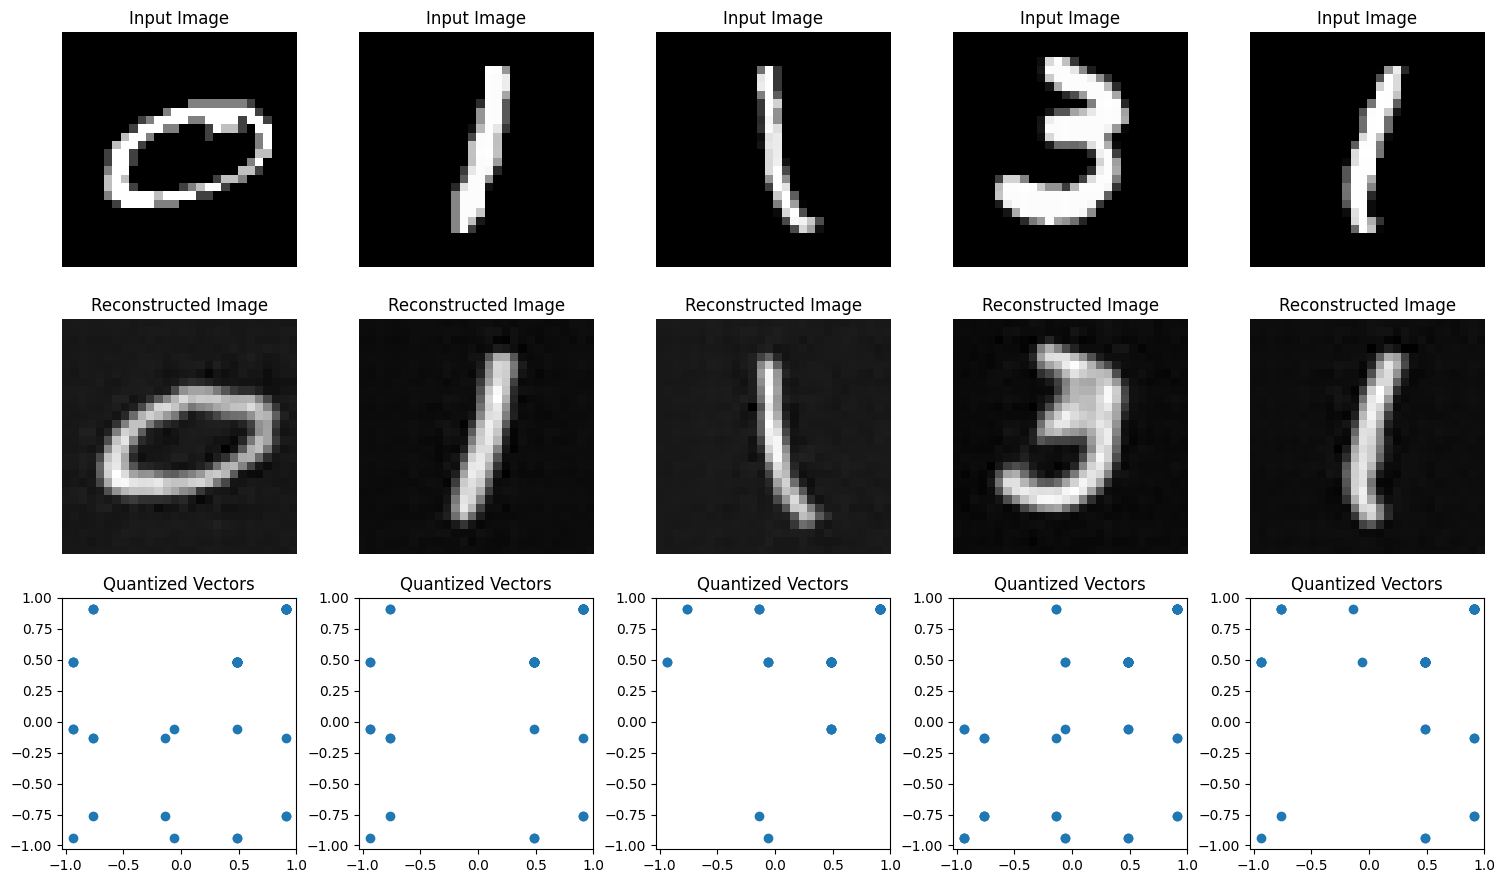

In [141]:
import matplotlib.pyplot as plt
import numpy as np

# Select 5 samples
samples, _ = next(iter(train_loader))
samples = samples[:5].to(device)

# Pass samples through the model
with torch.no_grad():
    recon_images, vq_loss, pqv = model(samples)


# Convert to numpy for plotting
samples = samples.cpu().numpy()
recon_images = recon_images.cpu().numpy()
quantized = pqv.cpu().numpy()

# Reshape the quantized vectors for plotting
quantized_reshaped = quantized.reshape(quantized.shape[0], -1, 2)


fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for i in range(5):
    # Plot input images
    axes[0, i].imshow(samples[i].reshape(28, 28), cmap='gray')
    axes[0, i].set_title('Input Image')
    axes[0, i].axis('off')

    # Plot reconstructed images
    axes[1, i].imshow(recon_images[i].reshape(28, 28), cmap='gray')
    axes[1, i].set_title('Reconstructed Image')
    axes[1, i].axis('off')

    # Plot quantized vectors
    axes[2, i].scatter(quantized_reshaped[i, :, 0], quantized_reshaped[i, :, 1])
    axes[2, i].set_title('Quantized Vectors')
    axes[2, i].axis('on')

plt.tight_layout()
plt.show()

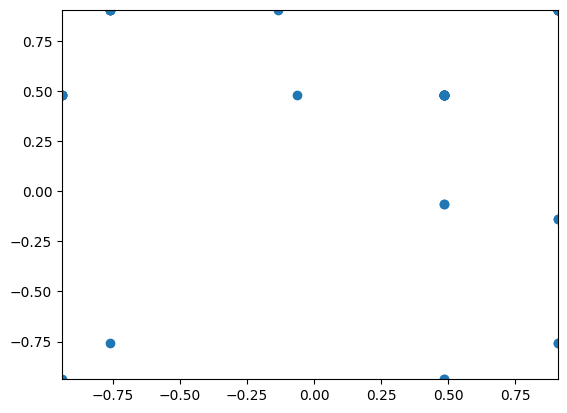

In [151]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

# Set up the figure and axis for the animation
fig, ax = plt.subplots()
points, = ax.plot([], [], 'o')
ax.set_xlim(np.min(quantized_reshaped[:, :, 0]), np.max(quantized_reshaped[:, :, 0]))
ax.set_ylim(np.min(quantized_reshaped[:, :, 1]), np.max(quantized_reshaped[:, :, 1]))

# Initialization function: plot the background of each frame
def init():
    points.set_data([], [])
    return points,

# Animation function: this is called sequentially
def animate(i):
    x = quantized_reshaped[i, :, 0]
    y = quantized_reshaped[i, :, 1]
    points.set_data(x, y)
    return points,

# Call the animator
anim = FuncAnimation(fig, animate, init_func=init, frames=5, interval=500, blit=True)

# Save the animation as a GIF
anim.save('quantized_vectors_animation.gif', writer='pillow')
plt.show()
